In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import copy
import random
import math
import matplotlib.pyplot as plt

import torch

# Embedding by PubMedBERT
from transformers import AutoTokenizer, AutoModel

# Heterogeneous Graph
from torch_geometric import transforms as T
from torch_geometric.data import HeteroData



## Paths

In [2]:
file_path = {
    'mirnas_tsv'  : 'our_data/nodes/mirnas.tsv',
    'mirnas_fasta': 'our_data/nodes/mirnas_seqs.fasta',
    'disease_tsv' : 'our_data/nodes/diseases.tsv',
    'pcg_tsv'     : 'our_data/nodes/pcgs.tsv',
    
    
    'mirnas_representations'  : 'our_data/nodes/mirna_representations/',
    'disease_representations' : 'our_data/nodes/disease_representations/',
    'pcg_representations'     : 'our_data/nodes/pcg_representations/',

    'mirna_mirna_tsv'    : 'our_data/edges/families_pre_mirna_pre_mirna.tsv',
    'disease_disease_tsv': 'our_data/edges/disease_disease.tsv',

    'pcg_pcg_humannet_tsv'    : 'our_data/edges/pcg_pcg_humannet.tsv',
    'mirna_pcg_mirtarbase_tsv': 'our_data/edges/mirna_pcg_mirtarbase.tsv',
    'pcg_disease_disgenet_tsv': 'our_data/edges/pcg_disease_disgenet.tsv',
    
    'graph_without_mda': 'our_data/data_without_mda.pt',

    'm_d_rnadisease': 'our_data/edges/mirna_disease_rnadisease.tsv',
    'm_d_hmdd_3': 'our_data/edges/mirna_disease_hmdd_3.tsv',
    'm_d_hmdd_4': 'our_data/edges/mirna_disease_hmdd_4.tsv',

    'train_val_test_timely'  : 'our_data/split/train_val_test_timely',
    'train_val_test_random'  : 'our_data/split/train_val_test_random',

    'known_unknown_subset': 'our_data/split/known_unknown_samples'
}

## Device

In [ ]:
device_name = 'cuda:0'

## PLM -> Embedding

### MiRNA Sequence - RNA-FM

In [ ]:
mirnas = pd.read_table(file_path['mirnas_tsv'])

with open(file_path['mirnas_fasta'], 'w') as file:
    for index, row in mirnas.iterrows():
        file.write(f">{row['Accession']}\n")
        file.write(f"{row['Sequence']}\n")
        file.write(f">{row['Mature1_Acc']}\n")
        file.write(f"{row['Mature1_Seq']}\n")
        if not pd.isna(row['Mature2_Seq']):
            file.write(f">{row['Mature2_Acc']}\n")
            file.write(f"{row['Mature2_Seq']}\n")

Run ``python launch/predict.py --config="pretrained/extract_embedding.yml" --data_path="../.././our_data/nodes/mirnas_seqs.fasta" --save_dir="../.././our_data/nodes" --save_frequency 1 --save_embeddings`` at "RNA-FM/redevelop"

### PubMedBERT

In [ ]:
device = torch.device(device_name if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained('PubMedBERT')
model = AutoModel.from_pretrained('PubMedBERT').to(device)

### Disease Text 
    - Embedding by PubMedBERT

In [ ]:
diseases = pd.read_table(file_path['disease_tsv'])

for index, row in diseases.iterrows():
    input = tokenizer([str(row['Disease Name']) + ': ' + str(row['MeSH Scope Note'])], return_tensors = 'pt')["input_ids"].to(device)
    hidden_states = model(input).last_hidden_state.squeeze(0)
    np.save(file_path['disease_representations'] + row['ID'] + '.npy', hidden_states.cpu().detach().numpy())

### PCG Name 
    - Embedding by PubmedBERT

In [ ]:
pcgs = pd.read_table(file_path['pcg_tsv'])
pcgs['Gene Groups'] = pcgs['Gene Groups'].fillna('Null')

for index, row in pcgs.iterrows():
    input = tokenizer([str(row['Name']) + ', belonging to the ' + str(row['Gene Groups'])], return_tensors = 'pt')["input_ids"].to(device)
    hidden_states = model(input).last_hidden_state.squeeze(0)
    np.save(file_path['pcg_representations'] + str(row['ID']) + '.npy', hidden_states.cpu().detach().numpy())

## Heterogeneous Graph
    - PyG

### Data without PCG and MDA

In [ ]:
mirnas_df = pd.read_table(file_path['mirnas_tsv'])
assert len(mirnas_df['Accession']) == len(mirnas_df['Accession'].unique())

mirna_id = pd.DataFrame(data={
    'mirna_id': mirnas_df['Accession'],
    'mapped_id': pd.RangeIndex(len(mirnas_df['Accession']))
    }
)

diseases_df = pd.read_table(file_path['disease_tsv'])
assert len(diseases_df['ID']) == len(diseases_df['ID'].unique())

disease_id = pd.DataFrame(data={
    'disease_id': diseases_df['ID'],
    'mapped_id': pd.RangeIndex(len(diseases_df['ID']))
})

In [ ]:
mirna_seq = []
# for idx, mirna in mirna_id['mirna_id'].items():
for idx, row in mirnas_df.iterrows():
    # tmp_mirna_pre = torch.from_numpy(np.load(file_path['mirnas_representations'] + mirna + '.npy')).float()
    tmp_mirna_pre = torch.from_numpy(np.load(file_path['mirnas_representations'] + row['Accession'] + '.npy')).float()
    tmp_mirna_pre = torch.mean(tmp_mirna_pre, axis=0)
    tmp_mirna_m1 = torch.from_numpy(np.load(file_path['mirnas_representations'] + row['Mature1_Acc'] + '.npy')).float()
    tmp_mirna_m1 = torch.mean(tmp_mirna_m1, axis=0)
    if pd.isna(row['Mature2_Seq']):
        tmp_mirna = torch.mean(torch.stack([tmp_mirna_pre, tmp_mirna_m1]), axis=0)
    else:
        tmp_mirna_m2 = torch.from_numpy(np.load(file_path['mirnas_representations'] + row['Mature2_Acc'] + '.npy')).float()
        tmp_mirna_m2 = torch.mean(tmp_mirna_m2, axis=0)
        tmp_mirna = torch.mean(torch.stack([tmp_mirna_pre, tmp_mirna_m1, tmp_mirna_m2]), axis=0)
    mirna_seq.append(tmp_mirna)
    # mirna_seq.append(tmp_mirna_pre)
mirna_x = torch.stack(mirna_seq)

In [ ]:
disease_text = []
for idx, disease in disease_id['disease_id'].items():
    tmp_disease = torch.from_numpy(np.load(file_path['disease_representations'] + disease + '.npy')).float()
    tmp_disease = torch.mean(tmp_disease, axis=0)
    disease_text.append(tmp_disease)
disease_x = torch.stack(disease_text)

In [ ]:
mirna_mirna_df = pd.read_table(file_path['mirna_mirna_tsv']).drop_duplicates()
mirna_mirna_df = mirna_mirna_df[(mirna_mirna_df['ID1'].isin(mirna_id['mirna_id'])) & (mirna_mirna_df['ID2'].isin(mirna_id['mirna_id']))]

mimi_mirna1_id = pd.merge(mirna_mirna_df['ID1'], mirna_id, left_on='ID1', right_on='mirna_id', how='left')
mimi_mirna1_id = torch.from_numpy(mimi_mirna1_id['mapped_id'].values)
mimi_mirna2_id = pd.merge(mirna_mirna_df['ID2'], mirna_id, left_on='ID2', right_on='mirna_id', how='left')
mimi_mirna2_id = torch.from_numpy(mimi_mirna2_id['mapped_id'].values)

assert torch.isnan(mimi_mirna1_id).any() == False
assert torch.isnan(mimi_mirna2_id).any() == False

disease_disease_df = pd.read_table(file_path['disease_disease_tsv'])[['ID1', 'ID2']].drop_duplicates()

dd_disease1_id = pd.merge(disease_disease_df['ID1'], disease_id, left_on='ID1', right_on='disease_id', how='left')
dd_disease1_id = torch.from_numpy(dd_disease1_id['mapped_id'].values)
dd_disease2_id = pd.merge(disease_disease_df['ID2'], disease_id, left_on='ID2', right_on='disease_id', how='left')
dd_disease2_id = torch.from_numpy(dd_disease2_id['mapped_id'].values)

assert torch.isnan(dd_disease1_id).any() == False
assert torch.isnan(dd_disease2_id).any() == False

Construct Heterogeneous Graph using mirna, disease and their relation

In [ ]:
data = HeteroData()

data['mirna'].node_id = torch.arange(len(mirna_id))
data['mirna'].x = mirna_x
data['disease'].node_id = torch.arange(len(disease_id))
data['disease'].x = disease_x

data['mirna', 'family', 'mirna'].edge_index = torch.stack([mimi_mirna1_id, mimi_mirna2_id], dim=0)
data['disease', 'fatherson', 'disease'].edge_index = torch.stack([dd_disease1_id, dd_disease2_id], dim=0)

# data = T.ToUndirected()(data)

Store Graph

In [ ]:
torch.save(data, 'our_data/data_without_pcg_and_mda.pt')

### Data without MDA

In [ ]:
# There are some circles in pcg-cpg edges, like (ID1 123, ID2 321) and (ID1 321, ID2 123).
# Here we should remove them
def sort_pcg_pcg(pcg_pcg_df):
    pcg_pcg_sorted = []
    for pcg_pcg in pcg_pcg_df.values:
        if pcg_pcg[0] < pcg_pcg[1]:
            pcg_pcg_sorted.append([pcg_pcg[0], pcg_pcg[1]])
        else:
            pcg_pcg_sorted.append([pcg_pcg[1], pcg_pcg[0]])
    return np.array(pcg_pcg_sorted)

In [ ]:
pcgs_df = pd.read_table(file_path['pcg_tsv'])
assert len(pcgs_df['ID']) == len(pcgs_df['ID'].unique())

pcg_id = pd.DataFrame(data={
    'pcg_id': pcgs_df['ID'],
    'mapped_id': pd.RangeIndex(len(pcgs_df['ID']))
})

pcg_name = []
for idx, pcg in pcg_id['pcg_id'].items():
    tmp_pcg = torch.from_numpy(np.load(file_path['pcg_representations'] + str(pcg) + '.npy')).float()
    tmp_pcg = torch.mean(tmp_pcg, axis=0)
    pcg_name.append(tmp_pcg)
pcg_x = torch.stack(pcg_name)

In [ ]:
pcg_pcg_df = pd.read_table(file_path['pcg_pcg_humannet_tsv']).drop_duplicates()
pcg_pcg_sorted = sort_pcg_pcg(pcg_pcg_df).T
pcg_pcg_df = pd.DataFrame({
    'ID1': pcg_pcg_sorted[0],
    'ID2': pcg_pcg_sorted[1]
}).drop_duplicates()

gg_pcg1_id = pd.merge(pcg_pcg_df['ID1'], pcg_id, left_on='ID1', right_on='pcg_id', how='left')
gg_pcg1_id = torch.from_numpy(gg_pcg1_id['mapped_id'].values)
gg_pcg2_id = pd.merge(pcg_pcg_df['ID2'], pcg_id, left_on='ID2', right_on='pcg_id', how='left')
gg_pcg2_id = torch.from_numpy(gg_pcg2_id['mapped_id'].values)

assert torch.isnan(gg_pcg1_id).any() == False
assert torch.isnan(gg_pcg2_id).any() == False

mirna_pcg_df = pd.read_table(file_path['mirna_pcg_mirtarbase_tsv'])[['miRBase Pre ID', 'Gene Entrez ID']].drop_duplicates()

mig_mirna_id = pd.merge(mirna_pcg_df['miRBase Pre ID'], mirna_id, left_on='miRBase Pre ID', right_on='mirna_id', how='left')
mig_mirna_id = torch.from_numpy(mig_mirna_id['mapped_id'].values)
mig_pcg_id = pd.merge(mirna_pcg_df['Gene Entrez ID'], pcg_id, left_on='Gene Entrez ID', right_on='pcg_id', how='left')
mig_pcg_id = torch.from_numpy(mig_pcg_id['mapped_id'].values)

assert torch.isnan(mig_mirna_id).any() == False
assert torch.isnan(mig_pcg_id).any() == False

pcg_disease_df = pd.read_table(file_path['pcg_disease_disgenet_tsv'])[['geneId', 'code']].drop_duplicates()

gd_pcg_id = pd.merge(pcg_disease_df['geneId'], pcg_id, left_on='geneId', right_on='pcg_id', how='left')
gd_pcg_id = torch.from_numpy(gd_pcg_id['mapped_id'].values)
gd_disease_id = pd.merge(pcg_disease_df['code'], disease_id, left_on='code', right_on='disease_id', how='left')
gd_disease_id = torch.from_numpy(gd_disease_id['mapped_id'].values)

assert torch.isnan(gd_pcg_id).any() == False
assert torch.isnan(gd_disease_id).any() == False

In [ ]:
data['pcg'].node_id = torch.arange(len(pcg_id))
data['pcg'].x = pcg_x

data['pcg', 'interaction', 'pcg'].edge_index = torch.stack([gg_pcg1_id, gg_pcg2_id], dim=0)
data['mirna', 'association', 'pcg'].edge_index = torch.stack([mig_mirna_id, mig_pcg_id], dim=0)
data['pcg', 'association', 'disease'].edge_index = torch.stack([gd_pcg_id, gd_disease_id], dim=0)

# data = T.ToUndirected()(data)

Store Graph

In [ ]:
torch.save(data, 'our_data/data_without_mda.pt')

### Conclusion

From separated tsv files to a unified HeteroData pt file

||File|Type|$\|N\|$|
|---|---|---|---|
|Nodes|diseases.tsv|Disease|5032|
||mirnas.tsv|MiRNA|1917|
||pcgs.tsv|PCG|19258|
|Edges Intra|disease_disease.tsv|Disease - Disease|7855|
||families_pre_mirna_pre_mirna.tsv|Pre MiRNA - Pre MiRNA|4500|
||pcg_pcg_humannet.tsv|PCG - PCG|1162441|
|Edges Inter|mirna_pcg_encori_degradome.tsv|MiRNA - PCG|144625|
||pcg_disease_disgenet.tsv|PCG - Disease|134796|

Finally, we have **data_without_mda.pt** and data_feature_randn_without_mda.pt!

## Training / Test Split

### Utils

In [4]:
def get_adj(posi_samples):
    """Obtain the adjacency matrix
    :posi_samples: Pandas DataFrame|Edge of (m, d)
    :return: Pandas DataFrame|Matrix of all nodes and 1 represents edge existing
    """
    mirnas = pd.read_table(file_path['mirnas_tsv'])
    assert len(mirnas['Accession']) == len(mirnas['Accession'].unique())
    diseases = pd.read_table(file_path['disease_tsv'])
    assert len(diseases['ID']) == len(diseases['ID'].unique())

    mda_adj = pd.DataFrame(
        index=mirnas['Accession'].drop_duplicates().values,
        columns=diseases['ID'].drop_duplicates().values
    )
    for mirna, disease in posi_samples.index:
        mda_adj.loc[mirna, disease] = 1

    mda_adj = mda_adj.fillna(0)
    return mda_adj

In [ ]:
# (m, d) -> (m', d) or (m, d')
def get_nega_samples(train_val_test, mda_adj, name, sampled):
    """Negative sample sampling by replacing an entity in an MDA pair
    :train_val_test: Dict|Positive sample dataset partitioning
    :mda_adj: Pandas DataFrame|The adjacency matrix of MDA
    :name: Str|Delineation of sampling
    :sampled: List|Negative samples that have been sampled
    :return: Dict|Adding negative samples for dataset partitioning
    """
    posi_samples = copy.copy(train_val_test[name]['posi'])
    random.shuffle(posi_samples)
    nega_samples = []

    # (m, d) -> (m, d')
    sample_num = {}
    for (m, d) in posi_samples[:math.ceil(len(posi_samples) / 2)]:
        if m in sample_num.keys():
            sample_num[m] += 1
        else:
            sample_num[m] = 1
    for key in sample_num.keys():
        unassociated_d = mda_adj.columns[mda_adj.loc[key] == 0]
        unassociated_and_not_sampled_d = [d for d in unassociated_d if (key, d) not in sampled]
        random_d = random.sample(unassociated_and_not_sampled_d, sample_num[key])
        nega_samples.extend([(key, d) for d in random_d])
        sampled = sampled.union(set([(key, d) for d in random_d]))
    
    # (m, d) -> (m', d)
    sample_num = {}
    for (m, d) in posi_samples[math.ceil(len(posi_samples) / 2):]:
        if d in sample_num.keys():
            sample_num[d] += 1
        else:
            sample_num[d] = 1
    for key in sample_num.keys():
        unassociated_m = mda_adj.index[mda_adj[key] == 0]
        unassociated_and_not_sampled_m = [m for m in unassociated_m if (m, key) not in sampled]
        if sample_num[key] > len(unassociated_and_not_sampled_m):
            print(key, sample_num[key], len(unassociated_and_not_sampled_m))
            nega_samples.extend([(m, key) for m in unassociated_and_not_sampled_m])
            sampled = sampled.union(set([(m, key) for m in unassociated_and_not_sampled_m]))
            continue
        random_m = random.sample(unassociated_and_not_sampled_m, sample_num[key])
        nega_samples.extend([(m, key) for m in random_m])
        sampled = sampled.union(set([(m, key) for m in random_m]))
    
    train_val_test[name]['nega'] = nega_samples
    
    return train_val_test, sampled

### Timely Split

In [5]:
mda_rnadisease = pd.read_table(file_path['m_d_rnadisease'])[['miRBase Pre ID', 'MeSH ID', 'Year']]
mda_hmdd_3 = pd.read_table(file_path['m_d_hmdd_3'])[['miRBase Pre ID', 'MeSH ID', 'Year']]
mda_hmdd_4 = pd.read_table(file_path['m_d_hmdd_4'])[['miRBase Pre ID', 'MeSH ID', 'Year']]
mda = pd.concat([mda_rnadisease, mda_hmdd_3, mda_hmdd_4])

year_value_counts =  mda.groupby(['miRBase Pre ID', 'MeSH ID']).Year.min().value_counts()

samples_num = year_value_counts.sum()
val_samples_num = year_value_counts[2020] + year_value_counts[2019]
test_samples_num = year_value_counts[2021] + year_value_counts[2022] + year_value_counts[2023] 
train_samples_num = samples_num - val_samples_num - test_samples_num

all_posi_samples = mda.groupby(['miRBase Pre ID', 'MeSH ID']).Year.min()

mda_adj = get_adj(all_posi_samples)

In [ ]:
train_val_test_timely = {
    'train': {
        'posi': all_posi_samples[all_posi_samples < 2019].index.to_list(),
        'nega': []
    },
    'val': {
        'posi': all_posi_samples[all_posi_samples.isin([2019, 2020])].index.to_list(),
        'nega': []
    },
    'test': {
        'posi': all_posi_samples[all_posi_samples.isin([2021, 2022, 2023, 2024])].index.to_list(),
        'nega': []
    }
}

In [ ]:
sampled = set()
train_val_test_timely, sampled = get_nega_samples(train_val_test_timely, mda_adj, 'train', sampled)
train_val_test_timely, sampled = get_nega_samples(train_val_test_timely, mda_adj, 'val', sampled)
train_val_test_timely, sampled = get_nega_samples(train_val_test_timely, mda_adj, 'test', sampled)

In [ ]:
np.save(file_path['train_val_test_timely'], train_val_test_timely)

#### Known and Unknown Subset

In [ ]:
def get_known_unknown_set(test_samples, diseases):
    test_sus_samples = []
    for mid in test_samples:
        if mid[1] in diseases:
            test_sus_samples.append(True)
        else:
            test_sus_samples.append(False)
    return test_sus_samples

In [ ]:
train_disease_degree = all_posi_samples[all_posi_samples < 2021].groupby(['MeSH ID']).agg('count').sort_values(ascending=False)

disease_unknown = set(mda_adj.columns) - set(train_disease_degree.index)
disease_known = set(train_disease_degree.index)

In [ ]:
train_val_test_timely = np.load(file_path['train_val_test_timely'], allow_pickle=True).item()
test_posi_samples = train_val_test_timely['test']['posi']
test_nega_samples = train_val_test_timely['test']['nega']

test_known_samples = get_known_unknown_set(test_posi_samples, disease_known) + get_known_unknown_set(test_nega_samples, disease_known)
test_unknown_samples = get_known_unknown_set(test_posi_samples, disease_unknown) + get_known_unknown_set(test_nega_samples, disease_unknown)
known_unknown_samples = {
    'known': test_known_samples,
    'unknown': test_unknown_samples
}

In [ ]:
np.save(file_path['known_unknown_subset'], known_unknown_samples)

#### Plot

In [6]:
def get_mirna_disease_index(mirna_id, disease_id, samples):
    
    mid_df = pd.DataFrame({
        'mirna': [tmp_sample[0] for tmp_sample in samples],
        'disease': [tmp_sample[1] for tmp_sample in samples]
    })
    
    mirna_index = pd.merge(mid_df['mirna'], mirna_id, left_on='mirna', right_on='mirna_id', how='left')['mapped_index'].values
    disease_index = pd.merge(mid_df['disease'], disease_id, left_on='disease', right_on='disease_id', how='left')['mapped_index'].values
    
    return mirna_index, disease_index

In [7]:
def plot_pred_posi_samples(all_posi_samples, nega_samples, posi_samples):

    mirna_ids = pd.read_table(file_path['mirna_tsv'])['Accession']
    known_mirna_degree = all_posi_samples[all_posi_samples < 2021].groupby(['miRBase Pre ID']).agg('count').sort_values(ascending=False)
    mirna_ids = known_mirna_degree.index.to_list() + list(list(set(mirna_ids) - set(known_mirna_degree.index)))
    mirna_id = pd.DataFrame(data={
        'mirna_id': mirna_ids,
        'mapped_index': pd.RangeIndex(len(mirna_ids))
    })

    disease_ids = pd.read_table(file_path['disease_tsv'])['ID']
    known_disease_degree = all_posi_samples[all_posi_samples < 2021].groupby(['MeSH ID']).agg('count').sort_values(ascending=False)
    disease_ids = known_disease_degree.index.to_list() + list(list(set(disease_ids) - set(known_disease_degree.index)))
    disease_id = pd.DataFrame(data={
        'disease_id': disease_ids,
        'mapped_index': pd.RangeIndex(len(disease_ids))
    })

    nega_mirna_index, nega_disease_index = get_mirna_disease_index(mirna_id, disease_id, nega_samples)
    posi_mirna_index, posi_disease_index = get_mirna_disease_index(mirna_id, disease_id, posi_samples)

    plt.figure(figsize=(len(disease_ids) / 100, len(mirna_ids) / 100))
    plt.axis([0, len(disease_ids), 0, len(mirna_ids)])
    # Test: Blue
    plt.scatter(nega_disease_index, nega_mirna_index, c='b', s=8)
    # Pred: Red
    plt.scatter(posi_disease_index, posi_mirna_index, c='r', s=8)

    vline_0 = len(known_disease_degree.index)
    h_top = len(mirna_ids)
    plt.vlines(vline_0, 0, h_top, colors='black', linewidth=5)

    font_text = {
        'family' : 'Noto Sans CJK JP',
        'fontweight' : 'bold',
        'size' : 72
    }

    v_top = len(disease_ids)
    plt.text((0 + vline_0) / 2, (0 + h_top) / 2, 'Known\nSubset', fontdict=font_text, ha='center', va='bottom')
    plt.text((vline_0 + v_top) / 2, (0 + h_top) / 2, 'Unknown\nSubset', fontdict=font_text, ha='center', va='bottom')

    font_label = {
        'family' : 'Noto Sans CJK JP',
        'weight' : 'normal',
        'size' : 72
    }
    plt.xlabel('Disease', font_label)
    plt.ylabel('miRNA', font_label)

    plt.legend(['Negative Samples', 'Positive Samples'], loc='upper right', prop=font_label, markerscale=16)

    plt.show()

findfont: Font family ['Noto Sans CJK JP'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Noto Sans CJK JP'] not found. Falling back to DejaVu Sans.


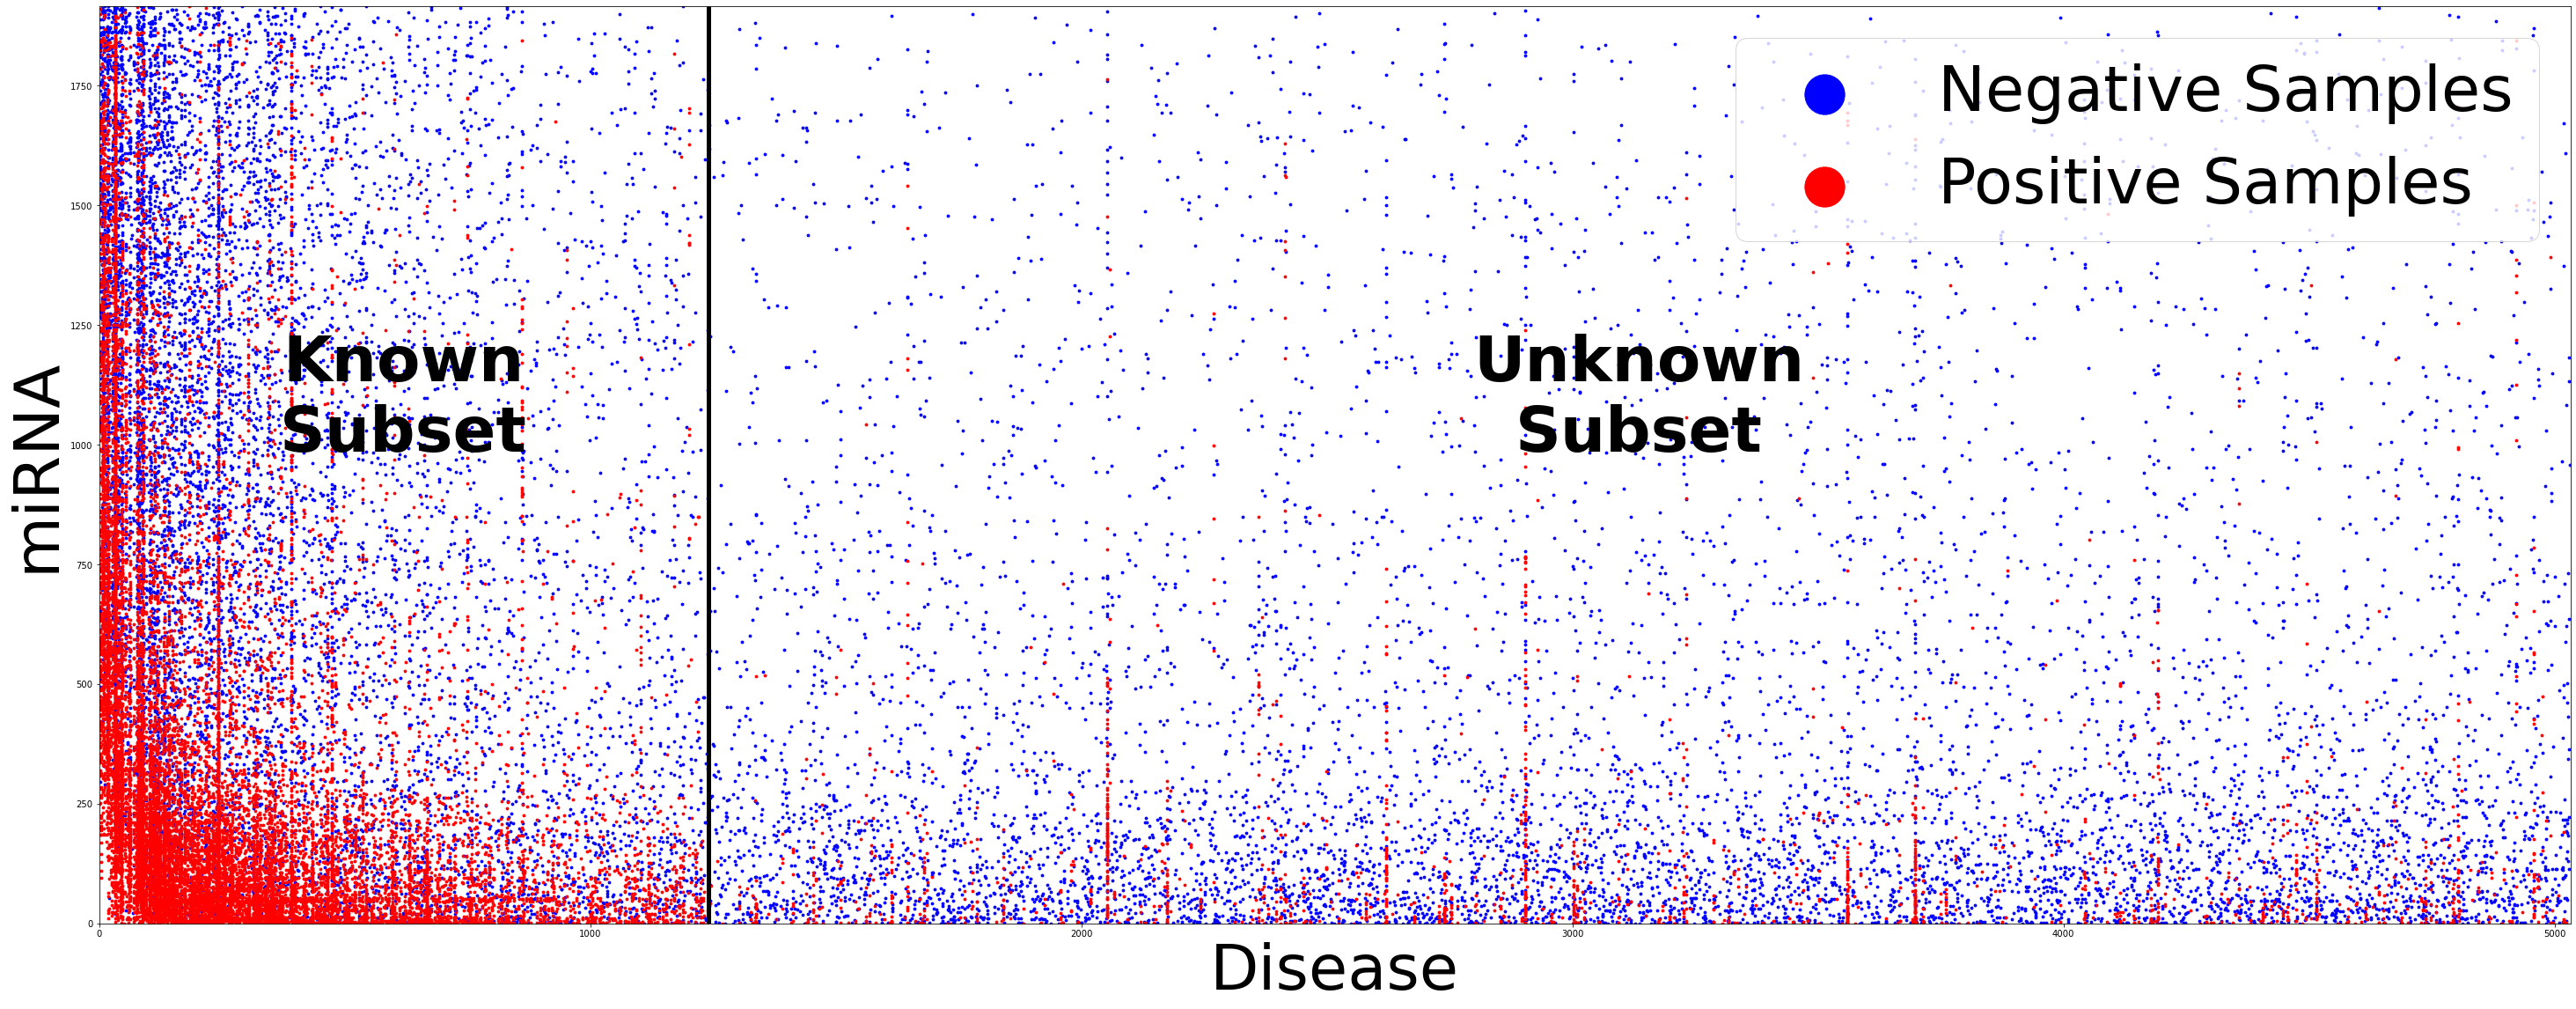

In [10]:
train_val_test = np.load(file_path['train_val_test_timely'] + '.npy', allow_pickle=True).item()

test_posi_samples = train_val_test['test']['posi']
test_nega_samples = train_val_test['test']['nega']

plot_pred_posi_samples(all_posi_samples, test_nega_samples, test_posi_samples)

### Random Split

In [ ]:
all_posi_samples_shuffled = all_posi_samples.index.to_list()
random.shuffle(all_posi_samples_shuffled)

In [ ]:
val_posi_samples_rand = all_posi_samples_shuffled[:val_samples_num]
train_posi_samples_rand = all_posi_samples_shuffled[val_samples_num: val_samples_num + train_samples_num]
test_posi_samples_rand = all_posi_samples_shuffled[val_samples_num + train_samples_num:]

In [ ]:
train_val_test_rand = {
    'train' : {
        'posi' : train_posi_samples_rand,
        'nega' : []
    },
    'val' : {
        'posi' : val_posi_samples_rand,
        'nega' : []
    },
    'test' : {
        'posi' : test_posi_samples_rand,
        'nega' : []
    },
}

In [ ]:
sampled = set()
train_val_test_rand, sampled = get_nega_samples(train_val_test_rand, mda_adj, 'train', sampled)
train_val_test_rand, sampled = get_nega_samples(train_val_test_rand, mda_adj, 'val', sampled)
train_val_test_rand, sampled = get_nega_samples(train_val_test_rand, mda_adj, 'test', sampled)

Store Dataset Split

In [ ]:
# np.save(file_path['train_val_test_random'], train_val_test_rand)